# Correction : Détection de Spam avec Ensemble Learning

## 1. Chargement des données

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [12]:
try:
    spam_data = fetch_openml('spambase', version=1, parser='auto')
    X = spam_data.data
    y = spam_data.target.astype(int)
    feature_names = spam_data.feature_names
except:
    np.random.seed(42)
    X, y = make_classification(
        n_samples=4601,
        n_features=57,
        n_informative=45,
        n_redundant=12,
        n_classes=2,
        weights=[0.6, 0.4],
        flip_y=0.05,
        random_state=42
    )
    X = np.abs(X)
    feature_names = (
        [f'word_freq_{w}' for w in ['make', 'address', 'all', 'free', 'business',
                                     'email', 'you', 'credit', 'money', 'order']] +
        [f'word_freq_generic_{i}' for i in range(1, 38)] +
        [f'char_freq_{c}' for c in ['semicolon', 'parenthesis', 'bracket',
                                     'exclamation', 'dollar', 'hashtag']] +
        ['capital_run_avg', 'capital_run_longest', 'capital_run_total']
    )

print(f"Dataset : {X.shape[0]} emails, {X.shape[1]} caracteristiques")
print(f"Proportion de spam : {y.mean():.1%}")

Dataset : 4601 emails, 57 caracteristiques
Proportion de spam : 39.4%


## 2. Exploration et préparation

In [13]:
print(f"Valeurs manquantes : {np.isnan(X).sum()}")
print(f"Distribution des classes : Ham={( y==0).sum()}, Spam={(y==1).sum()}")

Valeurs manquantes : word_freq_make                0
word_freq_address             0
word_freq_all                 0
word_freq_3d                  0
word_freq_our                 0
word_freq_over                0
word_freq_remove              0
word_freq_internet            0
word_freq_order               0
word_freq_mail                0
word_freq_receive             0
word_freq_will                0
word_freq_people              0
word_freq_report              0
word_freq_addresses           0
word_freq_free                0
word_freq_business            0
word_freq_email               0
word_freq_you                 0
word_freq_credit              0
word_freq_your                0
word_freq_font                0
word_freq_000                 0
word_freq_money               0
word_freq_hp                  0
word_freq_hpl                 0
word_freq_george              0
word_freq_650                 0
word_freq_lab                 0
word_freq_labs                0
word_freq_telnet   

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## 3. Modèles de base (Baseline)

On utilise des pipelines avec StandardScaler pour le preprocessing.

In [15]:
baseline_models = {
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'Naive Bayes': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GaussianNB())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42, probability=True))
    ])
}

In [16]:
results = []
predictions = {}

for name, pipeline in baseline_models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred

    results.append({
        'Modele': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })
    print(f"{name}: Accuracy={accuracy_score(y_test, y_pred):.3f} | Precision={precision_score(y_test, y_pred):.3f} | Recall={recall_score(y_test, y_pred):.3f}")

Decision Tree: Accuracy=0.911 | Precision=0.883 | Recall=0.893
Logistic Regression: Accuracy=0.929 | Precision=0.921 | Recall=0.898
Naive Bayes: Accuracy=0.833 | Precision=0.715 | Recall=0.959
SVM: Accuracy=0.927 | Precision=0.928 | Recall=0.884


## 4. Voting Classifier

On compare le **hard voting** (vote majoritaire) et le **soft voting** (probabilités).

In [17]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svm', SVC(random_state=42, probability=True))
]

hard_voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', VotingClassifier(estimators=estimators, voting='hard'))
])

soft_voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', VotingClassifier(estimators=estimators, voting='soft'))
])

hard_voting_pipeline.fit(X_train, y_train)
soft_voting_pipeline.fit(X_train, y_train)

y_pred_hard = hard_voting_pipeline.predict(X_test)
y_pred_soft = soft_voting_pipeline.predict(X_test)
predictions['Hard Voting'] = y_pred_hard
predictions['Soft Voting'] = y_pred_soft

for name, y_pred in [('Hard Voting', y_pred_hard), ('Soft Voting', y_pred_soft)]:
    results.append({
        'Modele': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })
    print(f"{name}: Accuracy={accuracy_score(y_test, y_pred):.3f} | Precision={precision_score(y_test, y_pred):.3f} | Recall={recall_score(y_test, y_pred):.3f}")

Hard Voting: Accuracy=0.936 | Precision=0.934 | Recall=0.901
Soft Voting: Accuracy=0.938 | Precision=0.937 | Recall=0.904


## 5. Tableau comparatif

In [18]:
results_sorted = sorted(results, key=lambda x: x['F1-Score'], reverse=True)

print(f"{'Modele':<22} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
for r in results_sorted:
    print(f"{r['Modele']:<22} {r['Accuracy']:>10.3f} {r['Precision']:>10.3f} {r['Recall']:>10.3f} {r['F1-Score']:>10.3f}")

Modele                   Accuracy  Precision     Recall   F1-Score
Soft Voting                 0.938      0.937      0.904      0.920
Hard Voting                 0.936      0.934      0.901      0.917
Logistic Regression         0.929      0.921      0.898      0.909
SVM                         0.927      0.928      0.884      0.906
Decision Tree               0.911      0.883      0.893      0.888
Naive Bayes                 0.833      0.715      0.959      0.819


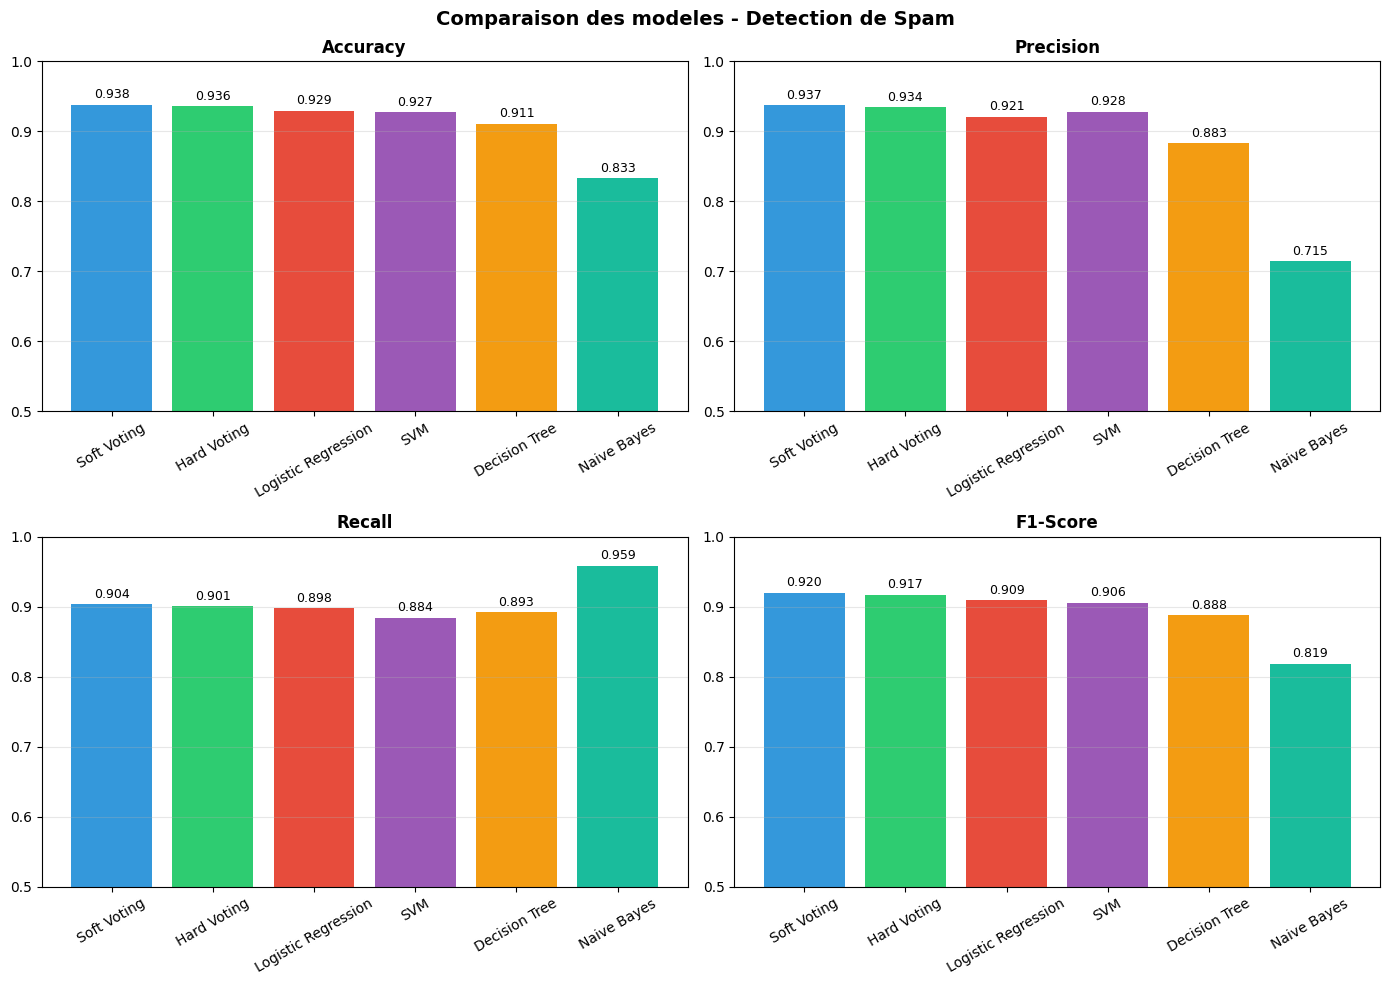

In [19]:
model_names = [r['Modele'] for r in results_sorted]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [r[metric] for r in results_sorted]
    bars = ax.bar(model_names, values, color=colors[:len(model_names)])
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.set_ylim([0.5, 1.0])
    ax.tick_params(axis='x', rotation=30)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Comparaison des modeles - Detection de Spam', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Analyse : quelle métrique est la plus importante ?

Pour un filtre anti-spam :

- **Precision** : Parmi les emails classés comme spam, combien sont vraiment des spams ?
  - Une faible precision = des emails légitimes bloqués par erreur (Faux Positifs)
  - Très problématique pour l'utilisateur : il manque des emails importants

- **Recall** : Parmi tous les spams, combien sont détectés ?
  - Un faible recall = des spams qui arrivent en boîte de réception (Faux Négatifs)
  - Gênant mais moins grave que de perdre un email légitime


## 7. Matrice de confusion du meilleur modèle

Meilleur modele : Soft Voting
F1-Score : 0.920


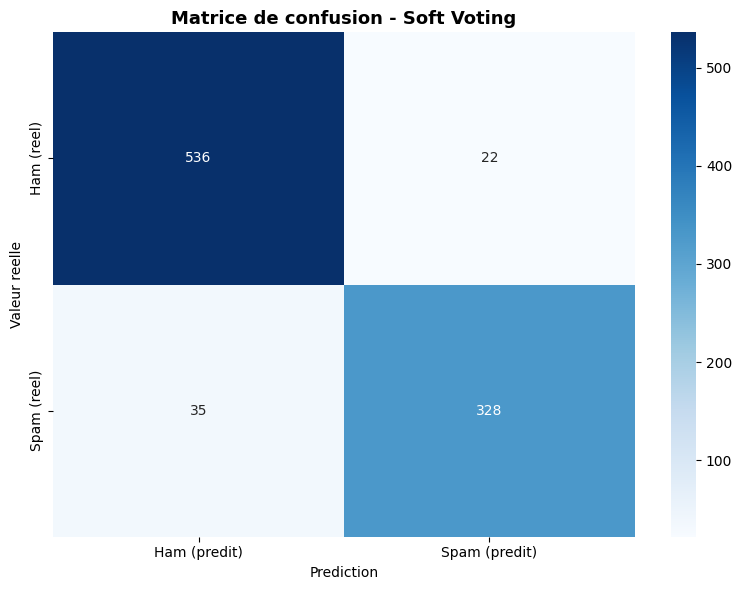


Emails legitimes bloques par erreur (Faux Positifs) : 22
Spams non detectes (Faux Negatifs)                  : 35


In [20]:
best_model_name = results_sorted[0]['Modele']
y_pred_best = predictions[best_model_name]

print(f"Meilleur modele : {best_model_name}")
print(f"F1-Score : {results_sorted[0]['F1-Score']:.3f}")

cm = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham (predit)', 'Spam (predit)'],
            yticklabels=['Ham (reel)', 'Spam (reel)'],
            ax=ax)
ax.set_title(f'Matrice de confusion - {best_model_name}', fontsize=13, fontweight='bold')
ax.set_xlabel('Prediction')
ax.set_ylabel('Valeur reelle')
plt.tight_layout()
plt.show()

print(f"\nEmails legitimes bloques par erreur (Faux Positifs) : {fp}")
print(f"Spams non detectes (Faux Negatifs)                  : {fn}")